# Estudo de Caso - GameWorld Analytics

Autor: Pedro Paulo de Freitas Santiago

Data: 08/07/2025

## Introdução

Este estudo de caso faz parte de um projeto final proposto pelo curso 'Google Data Analytics' oferecido pela Coursera. Neste notebook você encontrará a descrição de um problema de negócios de uma empresa fictícia, juntamente com todas as etapas da análise de dados.


###  Cenário

A empresa GameWorld Analytics, especializada em consultoria para desenvolvedores de jogos, está buscando entender melhor o cenário mundial dos jogos virtuais para identificar oportunidades de mercado em diferentes regiões e direcionar seus esforços e investimentos.

Ao longo dos anos, o mundo dos jogos se expandiu consideravelmente, saindo do escopo das plataformas dedicadas e aumentando cada vez mais sua base de consumidores em computadores e dispositivos móveis. Além disso, esse mercado se encontra bastante segmentado por regiões, onde diferentes nichos de jogadores consomem obras voltadas para seus interesses pessoais, que podem ser agrupadas através de características demográficas e geográficas.

Para entender melhor esse cenário, em conjunto com o setor executivo e o time de marketing, decidimos empreender um projeto para responder às seguintes questões relevantes para o futuro da empresa:

* Quais são os principais gêneros de jogos por região?
* Quais editoras possuem maior participação nos mercados regionais?
* Quais plataformas mais geraram receita ao longo do tempo?
* Existem franquias com maior potencial de lançamento de remasters?

###  Fonte de Dados



**Dataset**: Video Game Sales 2024

**Formato**: CSV

**Link**: <https://www.kaggle.com/datasets/asaniczka/video-game-sales-2024>

**Data de extração**: 08/07/2025


Os dados utilizados nesta análise são públicos e podem ser encontrados no link acima.

### Dicionário de Dados


In [1]:
#Importando bibliotecas e dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv("../data/vgchartz-2024.csv")

In [2]:
df.dtypes

img              object
title            object
console          object
genre            object
publisher        object
developer        object
critic_score    float64
total_sales     float64
na_sales        float64
jp_sales        float64
pal_sales       float64
other_sales     float64
release_date     object
last_update      object
dtype: object

Temos um total de 14 colunas no conjunto de dados.

Utilizando o Excel para criar um dicionário para os dados, podemos organizá-lo da seguinte forma:

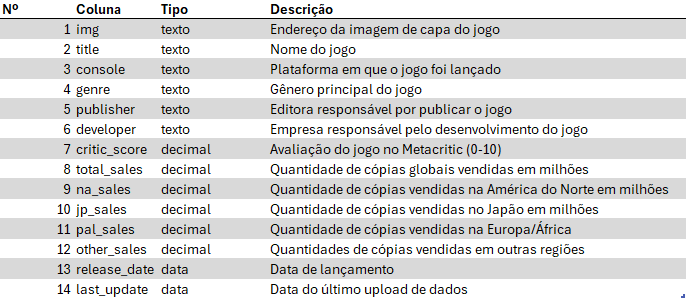


## Limpeza e Preparação de Dados

Para uma análise inicial, os dados foram importados para uma planilha Excel.

Primeiramente, utilizou-se o Power Query para normalizar os formatos dos dados e excluir as colunas *img* e *last_update*, que não possuem relevância para a nossa análise. Durante essa verificação, constatou-se que a tabela contém um número considerável de valores nulos em diferentes colunas.

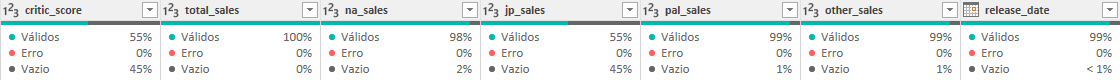

Para dar prosseguimento ao processo de limpeza, os dados foram inseridos em um banco de dados PostgreSQL para consultas mais complexas. Para isso, foi criada uma tabela: 

```sql

CREATE TABLE video_game_sales_2024 (
	id SERIAL PRIMARY KEY,
	title TEXT NOT NULL,
	console TEXT NOT NULL,
	genre TEXT NOT NULL,
	publisher TEXT,
	critic_score NUMERIC(2,1),
	total_sales NUMERIC(12,2),
	na_sales NUMERIC(12,2),
	jp_sales NUMERIC(12,2),
	pal_sales NUMERIC(12,2),
	other_sales NUMERIC(12,2),
	release_date DATE
);

Partindo da premissa de que os valores nulos, quando presentes em todas as colunas simultaneamente, correspondem à ausência de registros — e não à falta de vendas — filtrou-se a tabela para não exibir esses valores.

```sql

CREATE VIEW vendas_validas AS
SELECT *
FROM video_game_sales_2024
WHERE NOT (release_date IS NULL
	AND critic_score IS NULL
	AND total_sales IS NULL
	AND na_sales IS NULL
	AND jp_sales IS NULL
	AND pal_sales IS NULL
	AND other_sales IS NULL);

Os valores das colunas com a quantidade de vendas precisam estar na casa dos milhões, portanto, dividimos as todas por 100:

```sql
BEGIN;

UPDATE video_game_sales_2024
SET
  na_sales = na_sales / 100,
  jp_sales = jp_sales / 100,
  pal_sales = pal_sales / 100,
  other_sales = other_sales / 100,
  total_sales = total_sales / 100;

Algumas empresas apareciam com nomes diferentes, então normalizamos os nomes para não afetar a análise.

```sql

UPDATE video_game_sales_2024
SET publisher = 'Microsoft Game Studios'
WHERE publisher = 'Microsoft';


O conjunto de dados como um todo apresenta um grande valor de registros de vendas sem informação. Para tratar essa questão, vamos supor que os valores regionais nulos correspondem a jogos que venderam muito menos que um milhão de cópias.

Com isso em mente, substituímos os registros nulos por 0.

```sql

UPDATE video_game_sales_2024
SET
  total_sales = CASE WHEN total_sales IS NULL THEN 0 ELSE total_sales END,
  na_sales     = CASE WHEN na_sales     IS NULL THEN 0 ELSE na_sales END,
  jp_sales     = CASE WHEN jp_sales     IS NULL THEN 0 ELSE jp_sales END,
  pal_sales    = CASE WHEN pal_sales    IS NULL THEN 0 ELSE pal_sales END,
  other_sales  = CASE WHEN other_sales  IS NULL THEN 0 ELSE other_sales END;

 COMMIT;


Quanto aos valores nulos da coluna *critic_score*, não podemos fazer o mesmo, pois como veremos a seguir, há uma enorme quantidade de registros faltantes e uma baixa correlação entre o número de vendas e a avaliação das críticas:

<Axes: ylabel='Frequency'>

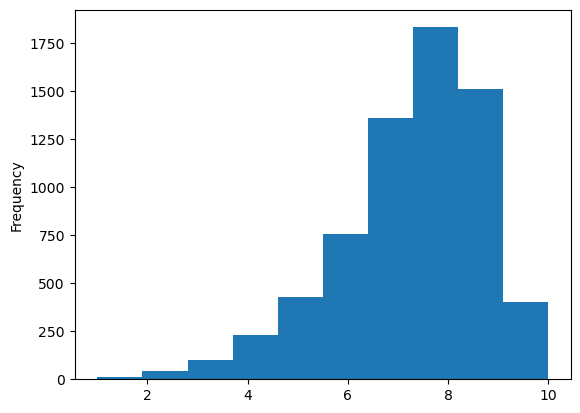

In [3]:
df['critic_score'].plot(kind = 'hist')

<Axes: >

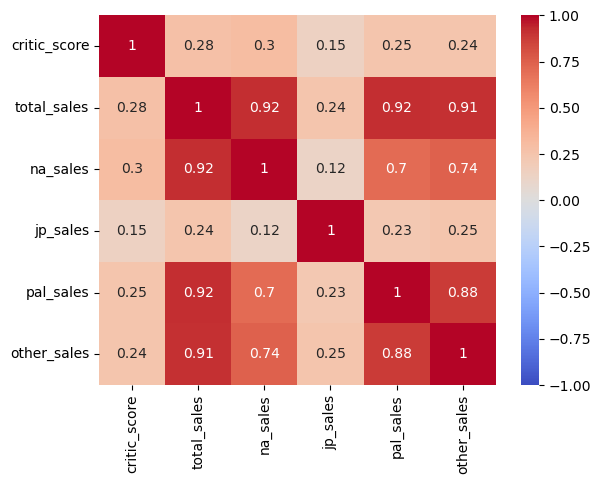

In [4]:
tabela_temp = df[df['critic_score'].notnull()]
sns.heatmap(tabela_temp[['critic_score', 'total_sales', 'na_sales', 'jp_sales', 'pal_sales', 'other_sales']].corr(), 
            vmin = -1, vmax =1, cmap='coolwarm', annot = True)

Portanto, não podemos supor que a ausência de valores em *critic_score* esteja relacionada a um baixo número de vendas. Assim, devemos considerar que durante a análise das avaliações críticas, muitos títulos não possuem valores mensuráveis, o que influenciará nos resultados apresentados.

## Análise 

A seguir, darei continuidade para a análise com base nas perguntas de negócio. Para isso, utilizei o Tableau para visualizar os dados a partir de gráficos para investigar individualmente, também disponibilizarei o dashboard completo com todas as visualizações dinâmicas ao final. 

Primeiramente, segmentamos nossa análises pelos indíces regionais.

In [13]:
%%HTML
<div class='tableauPlaceholder' id='viz1752161940207' style='position: relative'><noscript><a href='#'><img alt='Total de Vendas por Gênero e Região ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Te&#47;TendnciasnoMercadodeJogosEletrnicos&#47;GneroeRegioporVendas&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='TendnciasnoMercadodeJogosEletrnicos&#47;GneroeRegioporVendas' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Te&#47;TendnciasnoMercadodeJogosEletrnicos&#47;GneroeRegioporVendas&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='pt-BR' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1752161940207');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

**Insight**:

Gêneros de ação, esporte e jogos de tiro lideram em todas as regiões, com exceção do Japão, onde o gênero RPG (Role-Playing Game) possui maior presença quando comparado a todos os outros dentro da sua própria região, seguido de esporte e ação. 

Entretanto, a América do Norte ainda apresenta um maior número de vendas no gênero RPG do que o Japão.

O Japão também apresenta valores consideravelmente baixos de vendas quando comparado às demais regiões nos gêneros corrida, jogo de tiro e ação-aventura.

Vejamos agora as principais editoras em número de vendas e a participação de mercado de cada região:

In [12]:
%%HTML
<div class='tableauPlaceholder' id='viz1752162359370' style='position: relative'><noscript><a href='#'><img alt='Top 10 Editoras Segmentadas por Região ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Te&#47;TendnciasnoMercadodeJogosEletrnicos&#47;EditorasporRegio&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='TendnciasnoMercadodeJogosEletrnicos&#47;EditorasporRegio' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Te&#47;TendnciasnoMercadodeJogosEletrnicos&#47;EditorasporRegio&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='pt-BR' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1752162359370');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

**Insight**:

Novamente, encontramos um padrão semelhante ao do gráfico anterior. As principais editoras apresentam uma grande participação de todas as regiões, com exceção do Japão, que por sua vez, tem maior participação nos conglomerados de origem nacional, como Sony, Nintendo, Konami e Sega.

Importante notar que a EA Sports é um segmento da Electronic Arts, somando ambas as colunas, temos uma porção de vendas que supera a Activision.

O mercado norte-americano ainda permanece como principal consumidor da maioria das editoras.

Quanto aos gráficos que consideram as datas de lançamento, restringimos a análise até o ano de 2020, devido a ausência de valores em anos recentes na fonte de dados.

Mudamos a ênfase da análise agora para os consoles:

In [11]:
%%HTML
<div class='tableauPlaceholder' id='viz1752171434998' style='position: relative'><noscript><a href='#'><img alt='Acumulado de Vendas por Console ao Longo do Tempo ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Te&#47;TendnciasnoMercadodeJogosEletrnicos&#47;VendasdeConsole&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='TendnciasnoMercadodeJogosEletrnicos&#47;VendasdeConsole' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Te&#47;TendnciasnoMercadodeJogosEletrnicos&#47;VendasdeConsole&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='pt-BR' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1752171434998');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

**Insight**:

Percebe-se que os consoles da marca Sony dominaram o mercado até a metade da primeira década do século XXI, quando os consoles da Nintendo e Microsoft passaram a ganhar destaque no mercado.

Apesar da disputa acirrada entre o Xbox 360 e o Playstation 3 a partir de 2005, na geração seguinte (PS4 e Xbox One) a Sony retomou a liderança no mercado vendendo mais que o dobro dos seus concorrentes.

No segmento de consoles portáteis, a Nintendo manteve sua superioridade com seu Nintendo DS (Dual Screen).

In [9]:
%%HTML
<div class='tableauPlaceholder' id='viz1752172354695' style='position: relative'><noscript><a href='#'><img alt='Vendas por Franquia ao Longo do Tempo ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Te&#47;TendnciasnoMercadodeJogosEletrnicos&#47;VendasporFranquia&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='TendnciasnoMercadodeJogosEletrnicos&#47;VendasporFranquia' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Te&#47;TendnciasnoMercadodeJogosEletrnicos&#47;VendasporFranquia&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='pt-BR' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1752172354695');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>




Acima, temos a distribuição dos lançamentos de jogos das principais franquias do mercado de jogos mundial. Os principais títulos foram agrupados em uma nova coluna de franquias, filtrando lançamentos únicos; 

Franquias como FIFA e The Sims também foram retiradas pois são jogos que não possuem potencial de remaster/remake. Adicionei um leve jitter no eixo Y para tornar o gráfico mais legível.


**Insight**:

Call of Duty e GTA são as franquias com maior volume de vendas, porém, apresentam muitos lançamentos recentes, incluindo remasters de títulos anteriores.

Logo abaixo, vemos a franquia Halo e Assassin's Creed, ambas com títulos recentes, mas com jogos importantes datados a duas ou três gerações atrás.

Tomb Raider também se destaca por conter títulos muito antigos e com número relativamente alto de vendas para seus respectivos anos de lançamento, o baixo número de vendas de títulos recentes é um incentivo para o resgate de jogos anteriores.

É importante destacar que algumas franquias como Resident Evil, que apresentam número de vendas menor, ainda receberam vários remakes após 2019, o que indica que o número de vendas por si só não é fator decisivo para averiguar a popularidade e o potencial de remasters/remakes de uma franquia.

## Conclusão

Contextualizando os dados apresentados com nossas perguntas de negócio, darei prosseguimento com possíveis direcionamentos estratégicos para a empresa:

###   Mercados Regionais

É notável que há uma diferença considerável nas em alguns mercados baseado nas diferentes regiões analisadas anterioremente. Em particular, podemos destacar:

* Predominância de gêneros orientados a ação, tiro, esportes nos mercados ocidentais.
* Liderança do gênero RPG no mercado japonês.
* Empresas japonesas possuem grande presença no mercado mundial e principalmente no mercado de origem.
* EA, Activision tem presença dominante no mercado.

Com isso, sugerimos as seguintes abordagens:

1. Investimentos na prospecção de jogos de gêneros específicos orientados com base em mercados consumidores.
2. Investigar o crescimento regional de empresas de jogos japonêsas e sua popularidade nacional.

### Consoles e Plataformas

Se tratando dos principais consoles lançados nos últimos anos, há um domínio de três grandes players no mercado:

* Consoles de mesa: Microsoft e Sony
* Consoles portáteis: Sony e Nintendo

A partir disso, podemos: 

1. Segmentar clientes (desenvolvedores) com base nas plataformas que esses pretendem elaborar seus jogos, avaliando as chances de seus produtos permanecerem restritos a plataformas específicas.
2. Avaliar a possibilidade de encerrar o suporte a plataformas mais antigas.
3. Buscar contratos com as grandes produtoras para viabilizar os lançamentos de desenvolvedores "indies" em seus consoles.


### Franquias

Quanto às principais franquias destacadas:

* Call of Duty
* GTA
* Assassin's Creed
* Halo

Considerando o sucesso e o histórico, todas possuem potencialidade para remakes, mas a partir disso podemos elaborar outros tópicos:

1. Fazer uma análise mais profunda da popularidade das franquias a nível regional, dado que existem empresas com menos vendas apresentando muitos remasters/remakes nos últimos anos.
2. Acompanhar a recepção dos lançamentos de remakes mais recentes a fim de comparar com os resultados de títulos novos.